In [26]:
import numpy as np
from PIL import Image
import sys
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def pix2coord(x, y, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    long = (x / pixbd[0]) * (llbd[1] - llbd[0]) + llbd[0]
    lat = llbd[3] - (y / pixbd[1]) * (llbd[3] - llbd[2])
    return long, lat

In [2]:
# Open image, inport crater files
img_global = Image.open('utils/LunarLROLrocKaguya_118mperpix.png').convert("L")

/Users/silburt/anaconda2/envs/py36/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (2831155200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [4]:
dtype='dev'
craters = np.load('datasets/HEAD/HEAD_%s_craterdist_llt0.20_rt0.20.npy'%dtype)

#get GT
truthalan = pd.read_csv('utils/alanalldata.csv')
truthhead = pd.read_csv('utils/LolaLargeLunarCraterCatalog.csv')
truthhead = truthhead[(truthhead['Lat']>=-60)&(truthhead['Lat']<=60)]
truthalan = truthalan[(truthalan['Lat']>=-60)&(truthalan['Lat']<=60)]
if dtype == 'test':
    truthalan = truthalan[truthalan['Long']>60]        #region of test data
    truthhead = truthhead[(truthhead['Lon']>60)&(truthhead['Diam_km']>20.)]
elif dtype == 'dev':
    truthalan = truthalan[(truthalan['Long']>-60)&(truthalan['Long']<60)]        #region of test data
    truthhead = truthhead[(truthhead['Lon']<60)&(truthhead['Lon']>-60)&(truthhead['Diam_km']>20.)]

rad = np.concatenate((truthalan['Diameter (km)'].values/2.,truthhead['Diam_km'].values/2.))
long = np.concatenate((truthalan['Long'].values,truthhead['Lon'].values))
lat = np.concatenate((truthalan['Lat'].values,truthhead['Lat'].values))

GT_craters = np.column_stack((long, lat, rad))

In [27]:
def coord2pix(long, lat, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    x = (long - llbd[0]) / (llbd[1] - llbd[0]) * pixbd[0]
    y = (llbd[3] - lat) / (llbd[3] - llbd[2]) * pixbd[1]
    return x, y

def cropcraters(craters, llbd):
    return craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                   (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])]

In [20]:
def plot_craters(craters,GT_craters,xc,yc,rawlen):
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='int32')

    img = img_global.crop(box)
    llbd = pix2coord(box[0::2], box[1::2], img_global.size, [-180., 180., -60., 60.])
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    ctrs_sub = cropcraters(craters, llbd)
    GTctrs_sub = cropcraters(GT_craters, llbd)

    x, y = coord2pix(ctrs_sub.T[0], ctrs_sub.T[1], img.size, llbd)
    r = ctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    GTx, GTy = coord2pix(GTctrs_sub.T[0], GTctrs_sub.T[1], img.size, llbd)
    GTr = GTctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20, 10])
    ax1.imshow(np.asanyarray(img), cmap='Greys_r', vmin=75, vmax=200)
    ax1.set_title(llbd)
    ax2.imshow(np.asanyarray(img), cmap='Greys_r', vmin=75, vmax=200)
    ax2.set_title('Pred')
    ax3.imshow(np.asanyarray(img), cmap='Greys_r', vmin=75, vmax=200)
    ax3.set_title('GT')
    for k in range(len(ctrs_sub)):
        circle = plt.Circle((x[k], y[k]), r[k], color='blue', fill=False)
        ax2.add_artist(circle)
    for k in range(len(GTctrs_sub)):
        circle = plt.Circle((GTx[k], GTy[k]), GTr[k], color='red', fill=False)
        ax3.add_artist(circle)
    plt.savefig('output_dir/images/remap/xc%d_yc%d_rawlen%d.png'%(xc,yc,rawlen))
    plt.close()

In [21]:
#plot all areas of dev
rawlen = 3000
Nx = int((61400.-30800)/rawlen)
Ny = int(28000./rawlen)
xc, yc = 30800, 0

for j in range(Ny):
    for i in range(Nx):
        print("%d of %d"%(i+Nx*j,Nx*Ny))
        plot_craters(craters,GT_craters,xc,yc,rawlen)
        xc += rawlen
    xc = 30800
    yc += rawlen

0 of 90
1 of 90


KeyboardInterrupt: 

In [22]:
#plot individual
xc,yc,rawlen = 30800,0,6000
plot_craters(craters,GT_craters,xc,yc,rawlen)

## radius of craters (pixels) vs. rawlen

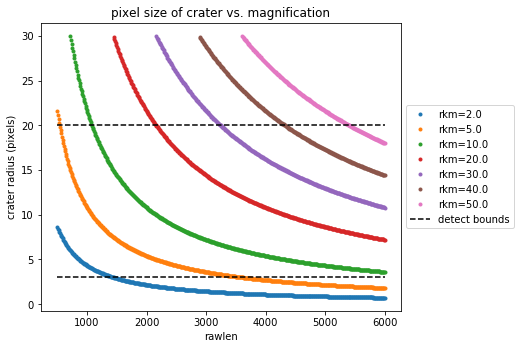

In [30]:
#automated
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.5,0.8])
rawlens = np.linspace(500,6000,500)
for rkm in [2,5,10,20,30,40,50]:
    bound, r = [], []
    for rawlen in rawlens:
        rpix = rkm/((rawlen/256.)*(np.pi / 180.0)*(1737.4/256))
        if rpix < 30:
            r.append(rpix)
            bound.append(rawlen)
    ax.plot(bound,r,'.',label='rkm=%.1f'%rkm)
ax.plot([min(rawlens),max(rawlens)],[20,20],'k--',label='detect bounds')
ax.plot([min(rawlens),max(rawlens)],[3,3],'k--')
leg = ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5),ncol=1)
ax.set_ylabel('crater radius (pixels)')
ax.set_xlabel('rawlen')
ax.set_title('pixel size of crater vs. magnification')
plt.savefig('output_dir/images/pix_vs_rawlen.png')